In [58]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]

drop_columns = []
for col in df.columns:
    if df[col].isnull().all() == True:
        drop_columns.append(col)
        
df.drop(columns=drop_columns, inplace=True)

df['pct_change'] = df.close.pct_change()
df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
df = df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/risk_adj_returns.pkl'

In [ ]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [55]:
df.tail()

905270  921795  904261  905261    916328  923024    936365  \
date                                                                     
2021-05-24     NaN     NaN     NaN     NaN -0.073424     NaN -0.026594   
2021-05-25     NaN     NaN     NaN     NaN -0.041516     NaN -0.023492   
2021-05-26     NaN     NaN     NaN     NaN -0.133718     NaN -0.022297   
2021-05-27     NaN     NaN     NaN     NaN -0.114582     NaN -0.030586   
2021-05-28     NaN     NaN     NaN     NaN -0.046110     NaN  0.001882   

            902355  912215  929813  ...    9660J1    69568X    543755  \
date                                ...                                 
2021-05-24     NaN     NaN     NaN  ... -0.042002  0.042352 -0.007893   
2021-05-25     NaN     NaN     NaN  ... -0.045774 -0.040381 -0.029872   
2021-05-26     NaN     NaN     NaN  ... -0.018214  0.006846 -0.041720   
2021-05-27     NaN     NaN     NaN  ... -0.050278 -0.001888 -0.039754   
2021-05-28     NaN     NaN     NaN  ... -0.059837 -0.051037 -0.046412   

              77463M    29235J    131745    69487D    68157P    9110RA  \
date                                                                     
2021-05-24 -0.034946 -0.006981  0.025437  0.006211 -0.034570  0.045914   
2021-05-25 -0.042776 -0.034353 -0.047507 -0.041449 -0.032225 -0.001858   
2021-05-26  0.014670  0.006996  0.050378 -0.030298  0.008515 -0.039008   
2021-05-27 -0.029330 -0.021043 -0.042413 -0.000474 -0.003118 -0.012079   
2021-05-28 -0.017292 -0.040496 -0.066158 -0.032654 -0.031242 -0.039250   

              292703  
date                  
2021-05-24 -0.023507  
2021-05-25 -0.073776  
2021-05-26 -0.103963  
2021-05-27  0.010919  
2021-05-28 -0.007592  

[5 rows x 1237 columns]

In [ ]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [39]:
tts = train_test_split(df, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [40]:
train.tail()

905270  921795  904261  905261    916328  923024    936365  \
date                                                                     
2015-02-09     NaN     NaN     NaN     NaN -0.163675     NaN -0.026913   
2015-02-10     NaN     NaN     NaN     NaN -0.043404     NaN -0.032232   
2015-02-11     NaN     NaN     NaN     NaN -0.077929     NaN -0.016328   
2015-02-12     NaN     NaN     NaN     NaN -0.053374     NaN -0.005984   
2015-02-13     NaN     NaN     NaN     NaN -0.002998     NaN -0.016736   

            902355  912215  929813  ...  9660J1    69568X    543755    77463M  \
date                                ...                                         
2015-02-09     NaN     NaN     NaN  ...     NaN -0.034316 -0.034879  0.028055   
2015-02-10     NaN     NaN     NaN  ...     NaN -0.044945 -0.048701 -0.024175   
2015-02-11     NaN     NaN     NaN  ...     NaN -0.063761 -0.033405  0.003297   
2015-02-12     NaN     NaN     NaN  ...     NaN -0.117544  0.022716 -0.024158   
2015-02-13     NaN     NaN     NaN  ...     NaN -0.027549 -0.066431  0.005881   

              29235J    131745    69487D    68157P    9110RA    292703  
date                                                                    
2015-02-09 -0.082390  0.014152 -0.082348  0.000718 -0.008729 -0.090909  
2015-02-10  0.036372 -0.002761 -0.017761 -0.005717 -0.040560 -0.020432  
2015-02-11 -0.025647 -0.015815  0.007270  0.020096 -0.031338  0.086688  
2015-02-12 -0.015127 -0.021643 -0.004011 -0.016497 -0.020532 -0.026762  
2015-02-13 -0.037008 -0.060536 -0.061752 -0.035843 -0.028278 -0.072243  

[5 rows x 1237 columns]

In [41]:
test.tail()

905270  921795  904261  905261    916328  923024    936365  \
date                                                                     
2021-05-24     NaN     NaN     NaN     NaN -0.073424     NaN -0.026594   
2021-05-25     NaN     NaN     NaN     NaN -0.041516     NaN -0.023492   
2021-05-26     NaN     NaN     NaN     NaN -0.133718     NaN -0.022297   
2021-05-27     NaN     NaN     NaN     NaN -0.114582     NaN -0.030586   
2021-05-28     NaN     NaN     NaN     NaN -0.046110     NaN  0.001882   

            902355  912215  929813  ...    9660J1    69568X    543755  \
date                                ...                                 
2021-05-24     NaN     NaN     NaN  ... -0.042002  0.042352 -0.007893   
2021-05-25     NaN     NaN     NaN  ... -0.045774 -0.040381 -0.029872   
2021-05-26     NaN     NaN     NaN  ... -0.018214  0.006846 -0.041720   
2021-05-27     NaN     NaN     NaN  ... -0.050278 -0.001888 -0.039754   
2021-05-28     NaN     NaN     NaN  ... -0.059837 -0.051037 -0.046412   

              77463M    29235J    131745    69487D    68157P    9110RA  \
date                                                                     
2021-05-24 -0.034946 -0.006981  0.025437  0.006211 -0.034570  0.045914   
2021-05-25 -0.042776 -0.034353 -0.047507 -0.041449 -0.032225 -0.001858   
2021-05-26  0.014670  0.006996  0.050378 -0.030298  0.008515 -0.039008   
2021-05-27 -0.029330 -0.021043 -0.042413 -0.000474 -0.003118 -0.012079   
2021-05-28 -0.017292 -0.040496 -0.066158 -0.032654 -0.031242 -0.039250   

              292703  
date                  
2021-05-24 -0.023507  
2021-05-25 -0.073776  
2021-05-26 -0.103963  
2021-05-27  0.010919  
2021-05-28 -0.007592  

[5 rows x 1237 columns]

In [42]:
# Feature Scaling
# sc = MinMaxScaler(feature_range = (0, 1))
# training_set_scaled = sc.fit_transform(train)
# test_set_scaled = sc.fit_transform(test)
# pd.DataFrame(training_set_scaled).head()

## Simple multi-layer percepetron (MLP) autoencoder

In [43]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# Can be normalized with a MinMaxScaler to the range [0,1]??

window_length = training_set_scaled.shape[1]
encoding_dim = 3
epochs = 250

# compress the input to a 3-dimensional latent space.
# the input and output of the autoencoder for 10 randomly selected price return windows extracted 
# from the test dataset  

# input placeholder
input_window = Input(shape=(window_length,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# lossy reconstruction of the input
decoded = Dense(window_length, activation='linear')(encoded) #linear

# model mapping an input to its reconstruction
autoencoder = Model(input_window, decoded)

# model mapping an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='MeanSquaredError') #MSE
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = autoencoder.predict(test_set_scaled)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1238)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3717      
_________________________________________________________________
dense_3 (Dense)              (None, 1238)              4952      
Total params: 8,669
Trainable params: 8,669
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
7/7 [==============================] - 1s 53ms/step - loss: nan - val_loss: nan
Epoch 2/250
7/7 [==============================] - 0s 20ms/step - loss: nan - val_loss: nan
Epoch 3/250
7/7 [==============================] - 0s 18ms/step - loss: nan - val_loss: nan
Epoch 4/250
7/7 [==============================] - 0s 19ms/step - loss: nan - val_loss: nan
Epoch 5/250
7/7 [==

7/7 [==============================] - 0s 17ms/step - loss: nan - val_loss: nan
Epoch 82/250
7/7 [==============================] - 0s 16ms/step - loss: nan - val_loss: nan
Epoch 83/250
7/7 [==============================] - 0s 22ms/step - loss: nan - val_loss: nan
Epoch 84/250
7/7 [==============================] - 0s 16ms/step - loss: nan - val_loss: nan
Epoch 85/250
7/7 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 86/250
7/7 [==============================] - 0s 19ms/step - loss: nan - val_loss: nan
Epoch 87/250
7/7 [==============================] - 0s 24ms/step - loss: nan - val_loss: nan
Epoch 88/250
7/7 [==============================] - 0s 20ms/step - loss: nan - val_loss: nan
Epoch 89/250
7/7 [==============================] - 0s 20ms/step - loss: nan - val_loss: nan
Epoch 90/250
7/7 [==============================] - 0s 19ms/step - loss: nan - val_loss: nan
Epoch 91/250
7/7 [==============================] - 0s 18ms/step - loss: nan - val_

7/7 [==============================] - 0s 33ms/step - loss: nan - val_loss: nan
Epoch 169/250
7/7 [==============================] - 0s 35ms/step - loss: nan - val_loss: nan
Epoch 170/250
7/7 [==============================] - 0s 27ms/step - loss: nan - val_loss: nan
Epoch 171/250
7/7 [==============================] - 0s 30ms/step - loss: nan - val_loss: nan
Epoch 172/250
7/7 [==============================] - 0s 30ms/step - loss: nan - val_loss: nan
Epoch 173/250
7/7 [==============================] - 0s 43ms/step - loss: nan - val_loss: nan
Epoch 174/250
7/7 [==============================] - 0s 42ms/step - loss: nan - val_loss: nan
Epoch 175/250
7/7 [==============================] - 0s 27ms/step - loss: nan - val_loss: nan
Epoch 176/250
7/7 [==============================] - 0s 28ms/step - loss: nan - val_loss: nan
Epoch 177/250
7/7 [==============================] - 0s 37ms/step - loss: nan - val_loss: nan
Epoch 178/250
7/7 [==============================] - 0s 29ms/step - loss: 

In [44]:
pd.DataFrame(encoder.predict(test_set_scaled))

0   1   2
0    NaN NaN NaN
1    NaN NaN NaN
2    NaN NaN NaN
3    NaN NaN NaN
4    NaN NaN NaN
...   ..  ..  ..
1578 NaN NaN NaN
1579 NaN NaN NaN
1580 NaN NaN NaN
1581 NaN NaN NaN
1582 NaN NaN NaN

[1583 rows x 3 columns]

In [45]:
pd.DataFrame(decoded_stocks)

0     1     2     3     4     5     6     7     8     9     ...  1228  \
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1578   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1579   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1580   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1581   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
1582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

      1229  1230  1231  1232  1233  1234  1235  1236  1237  
0      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1578   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1579   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1580   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1581   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1582   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[1583 rows x 1238 columns]

In [46]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

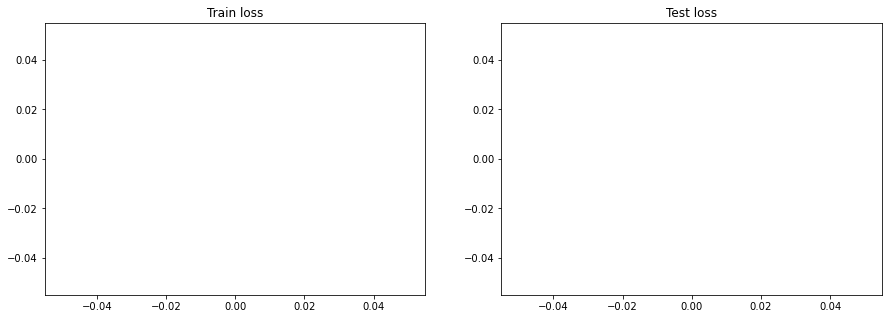

In [47]:
# Loss vs Epoch
plot_history(history)

## 1D convolutional autoencoder
(Kernel size = 3)

In [ ]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)